In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#####
# Cross-CL pipeline plotter. 
# Plots:
#  a) residuals CL_data - CL_model(MAP params) for both models
#  b) best-fit CMB model (containing r_MAP and A_lens_MAP) for both models
#  c) lensing template 

# Input: 
# From 100 simulations containing goal optimistic noise + dmsm foregrounds, need:
# * CAMB templates 'lens_nobb' (A_lens=1, r=0) and 'lens_r1' (A_lens=1, r=1)
# * Coadded BB D_ells from 100 simulations (np array, shape (nsims=100,nbpws=27,nbands=6,nbands=6))
# * Coadded BB D_ells error bars (np array, shape (nbpws=27,nbands=6,nbands=6))
# * CL-fiducial MAP parameters (txt, 100+1 rows, 9+1 columns)
# * CL-moments MAP parameters (txt, 100+1 rows, 13+1 columns)
# * CL-fiducial predicted D_ells from 100 simulations (np array, shape (nsims=100,nbpws=27,nbands=6,nbands=6))
# * CL-moments predicted D_ells from 100 simulations (np array, shape (nsims=100,nbpws=27,nbands=6,nbands=6))

In [3]:
def get_triangle_axes():
    nbins=6
    fig, axes = plt.subplots(nbins, nbins,
                             figsize=(15, 10),
                             sharex=True,
                             sharey=True)
    for b1 in range(nbins) :
        for b2 in range(nbins) :
            if b2<b1 :
                axes[b2,b1].axis('off')
    return axes

In [4]:
####
# 2: Read data
camb_lens_nobb_path = 'data/camb_lens_nobb_nico.dat' 
camb_lens_r1_path = 'data/camb_lens_r1_nico.dat'
dells_path = 'data/dells_coadded.npz'
dells_model_fid_path = 'data/dells_coadded_model_cl_fiducial.npz'
params_fid_path = 'data/params_cl_fiducial.txt' 
dells_model_mom_path = 'data/dells_coadded_model_cl_moments.npz' # TODO: Replace file with true moments results. 
params_mom_path = 'data/params_cl_moments.txt'                   # TODO: Replace file with true moments results. 

# templates
cmb_ls = np.loadtxt(camb_lens_r1_path)[:,0]
mask = (cmb_ls <= 300) & (cmb_ls > max(1,30))
ls = cmb_ls[mask]
cmb_r1 = np.loadtxt(camb_lens_r1_path)[:,3][mask]
cmb_tens = (np.loadtxt(camb_lens_r1_path)[:,3] - np.loadtxt(camb_lens_nobb_path)[:,3])[mask]
cmb_lens = np.loadtxt(camb_lens_nobb_path)[:,3][mask]

# data
ells = np.load(dells_path)['l']
dells_err = np.load(dells_path)['el']
dells_mom = np.load(dells_model_mom_path)['dl']
residual_dells_fid = np.mean(np.load(dells_path)['dl'] - np.load(dells_model_fid_path)['dl'], axis=0)
residual_dells_mom = np.mean(np.load(dells_path)['dl'] - np.load(dells_model_mom_path)['dl'], axis=0)

# parameters
with open(params_fid_path) as fid:
    fid_names = np.array(fid.readline().strip().split()[1:])
fid_params = np.loadtxt(params_fid_path)[:,1:]
r_fid = np.mean(fid_params[:,np.where(fid_names=='r_tensor')])
AL_fid = np.mean(fid_params[:,np.where(fid_names=='A_lens')])
with open(params_mom_path) as mom:
    mom_names = np.array(mom.readline().strip().split()[1:])
mom_params = np.loadtxt(params_mom_path)[:,1:]
r_mom = np.mean(mom_params[:,np.where(mom_names=='r_tensor')])
AL_mom = np.mean(mom_params[:,np.where(mom_names=='A_lens')])

cmb_dls_fid = r_fid*cmb_tens + AL_fid*cmb_lens
cmb_dls_mom = r_mom*cmb_tens + AL_mom*cmb_lens
print('r:', r_fid, '(fid)', r_mom, '(mom), AL:', AL_fid, '(fid)', AL_mom, '(mom)')

r: 0.004062667748280666 (fid) 0.004062667748280666 (mom), AL: 0.9895584450365817 (fid) 0.9895584450365817 (mom)


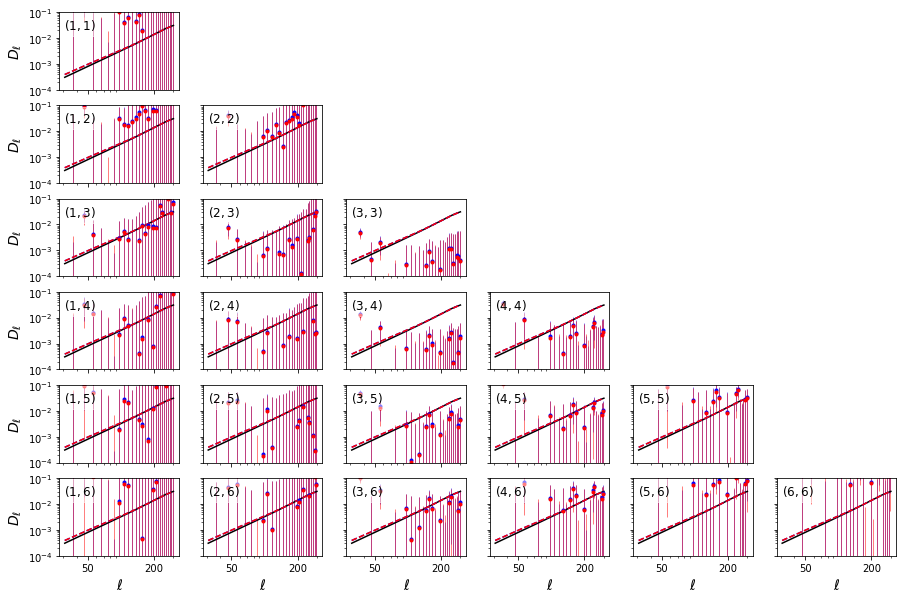

In [5]:
####
# 3: Make plot.
axes = get_triangle_axes()
for i1 in range(6):
    for i2 in range(i1,6):
        ax = axes[i2, i1]
        ax.plot(ls, cmb_lens, 'k-')
        ax.errorbar(ells, residual_dells_fid[:,i1,i2], yerr=dells_err[:,i1,i2], fmt='b.', elinewidth=.5)
        ax.plot(ls, cmb_dls_fid, 'b--')
        # Factor 0.9 below is just for demonstration. TODO: remove once real moments data are included!
        ax.errorbar(ells, 0.9*residual_dells_mom[:,i1,i2], yerr=dells_err[:,i1,i2], fmt='r.', elinewidth=.5)
        ax.plot(ls, cmb_dls_mom, 'r--')
        ax.set_ylim([1e-4, 1e-1])
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xticks([50,200])
        ax.set_xticklabels([50,200])
        props = dict(facecolor='white', alpha=0.5, edgecolor='white')
        ax.text(0.04, 0.78, f'$({i1+1},{i2+1})$',
                transform=ax.transAxes, fontsize=12, bbox=props)
        if i2 == 5:
            ax.set_xlabel(r'$\ell$', fontsize=14)
        if i1 == 0:
            ax.set_ylabel(r'$D_\ell$', fontsize=14)
plt.savefig('data/plots_dells.pdf')
plt.show()